# Part 2 — LEARN: Layoff Risk Models

Follow the project guide: define a binary layoff-risk target, train Decision Tree + Random Forest, and report accuracy/confusion matrices. Bonus: add F1/ROC and interpret FP/FN cases.

## Goals
- Target: `target_high_risk` (1 = layoff ratio above 5% or recent high impact).
- Models: Decision Tree, Random Forest with one-hot encoded categorical features.
- Metrics: accuracy, confusion matrix; bonus F1/ROC to mirror the guide.
- Explain why any false positives/negatives appear.

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')
NOTEBOOK_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()
DATA_PATH = (NOTEBOOK_DIR.parent / 'Data' / 'cleaned_dataset.csv').resolve()
print('Using data at', DATA_PATH)


Using data at C:\Users\Daniel\Downloads\NEU_6105_Finall\Data\cleaned_dataset.csv


In [2]:
# Load dataset

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(142, 11)


,company,industry,headquarter_location,status,layoffs_12m,layoffs_last90d,days_since_last_layoff,total_employees_est,layoff_ratio,impacted_pct_recent,target_high_risk
0,glorifi,fintech,dallas,private,100.0,100.0,1094,1209.090909,0.12,1.00,1
1,assure,fintech,salt lake city,private,100.0,100.0,1092,1209.090909,0.12,1.00,1
2,ncx,"renewable energy, forestry",san francisco,private,100.0,100.0,1087,1209.090909,0.12,0.40,1
3,blockfi,crypto,jersey city,private,100.0,100.0,1087,4906.976744,0.12,1.00,1
4,candy digital,cryptocurrency,new york,private,33.0,33.0,1087,100.000000,0.33,0.33,1


In [3]:
# Class balance

target_col = 'target_high_risk'
class_counts = df[target_col].value_counts().rename({0: 'low_risk', 1: 'high_risk'})
class_pct = (class_counts / len(df) * 100).round(1)
display(pd.DataFrame({'count': class_counts, 'pct': class_pct}))


,count,pct
target_high_risk,,
high_risk,115,81.0
low_risk,27,19.0


In [4]:
# Train/test split + preprocessing

X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = ['company', 'industry', 'headquarter_location', 'status']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough',
)


In [5]:
def fit_and_eval(model, model_name: str):
    """Train a model inside the preprocessing pipeline and compute metrics."""
    pipe = Pipeline([
        ('prep', preprocess),
        ('model', model),
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    f1_pos = report['1']['f1-score']
    recall_pos = report['1']['recall']
    auc = roc_auc_score(y_test, proba) if proba is not None else None

    print(f"{model_name} accuracy: {acc:.3f}")
    print(f"F1 (positive class): {f1_pos:.3f} | Recall (positive): {recall_pos:.3f}")
    print('Confusion matrix:')
    print(cm)

    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        preds,
        display_labels=['Low risk', 'High risk'],
        ax=ax,
        colorbar=False,
    )
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.show()

    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba, name=model_name)
        plt.show()

    return {
        'pipeline': pipe,
        'preds': preds,
        'proba': proba,
        'cm': cm,
        'metrics': {
            'model': model_name,
            'accuracy': acc,
            'f1_positive': f1_pos,
            'recall_positive': recall_pos,
            'roc_auc': auc,
        },
        'report': report,
    }


### Decision Tree (core model)

Decision Tree accuracy: 0.931
F1 (positive class): 0.955 | Recall (positive): 0.913
Confusion matrix:
[[ 6  0]
 [ 2 21]]


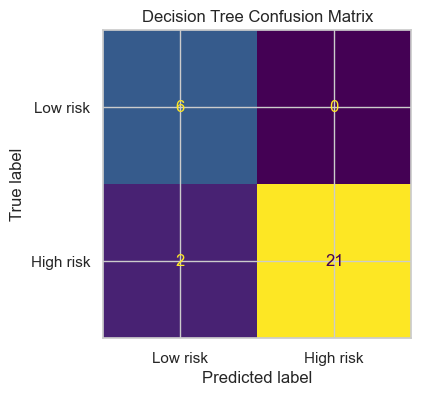

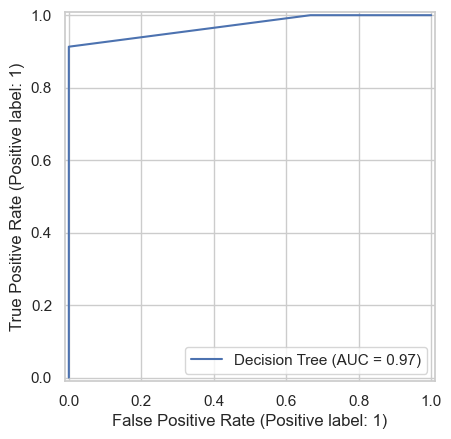

In [6]:
dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
)

dt_results = fit_and_eval(dt_model, 'Decision Tree')


### Random Forest (core model)

Random Forest accuracy: 0.862
F1 (positive class): 0.920 | Recall (positive): 1.000
Confusion matrix:
[[ 2  4]
 [ 0 23]]


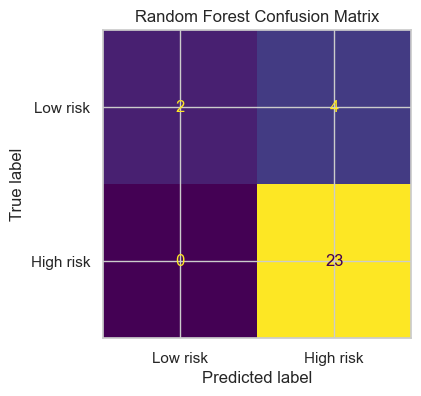

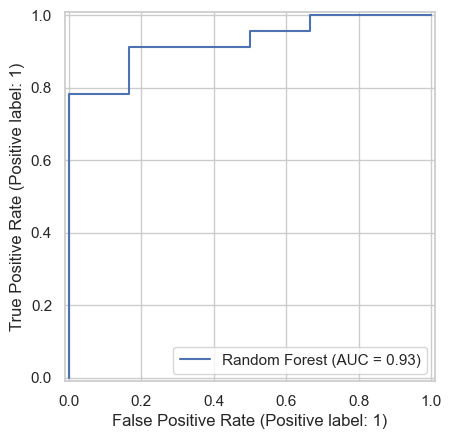

In [7]:
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=1,
)

rf_results = fit_and_eval(rf_model, 'Random Forest')


In [8]:
# Compare metrics side-by-side

metrics_df = pd.DataFrame([dt_results['metrics'], rf_results['metrics']])
metrics_df.set_index('model', inplace=True)
metrics_df


,accuracy,f1_positive,recall_positive,roc_auc
model,,,,
Decision Tree,0.931034,0.954545,0.913043,0.971014
Random Forest,0.862069,0.920000,1.000000,0.927536


## Save best model
Train the Decision Tree on the full dataset and persist to `Model/best_model.pkl` for reuse.


In [9]:
# Fit Decision Tree on full data and save for inference

best_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
)

best_pipeline = Pipeline([
    ('prep', preprocess),
    ('model', best_model),
])
best_pipeline.fit(X, y)

MODEL_DIR = NOTEBOOK_DIR.parent / "Model"
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "best_model.pkl"
dump(best_pipeline, MODEL_PATH)
print("Saved best model to", MODEL_PATH)


Saved best model to C:\Users\Daniel\Downloads\NEU_6105_Finall\Model\best_model.pkl


### False positives / false negatives (Decision Tree)
The Decision Tree has higher overall accuracy, so we inspect its errors below.

In [10]:
analysis_df = X_test.copy()
analysis_df['actual'] = y_test.values
analysis_df['pred'] = dt_results['preds']

fps = analysis_df[(analysis_df['actual'] == 0) & (analysis_df['pred'] == 1)]
fns = analysis_df[(analysis_df['actual'] == 1) & (analysis_df['pred'] == 0)]

print('False positives:', len(fps))
print('False negatives:', len(fns))

cols_to_show = ['company', 'industry', 'layoff_ratio', 'layoffs_12m', 'days_since_last_layoff', 'impacted_pct_recent', 'actual', 'pred']

print('Sample false positives (if any):')
display(fps[cols_to_show].head())

print('Sample false negatives (if any):')
display(fns[cols_to_show].head())


False positives: 0
False negatives: 2
Sample false positives (if any):


,company,industry,layoff_ratio,layoffs_12m,days_since_last_layoff,impacted_pct_recent,actual,pred


Sample false negatives (if any):


,company,industry,layoff_ratio,layoffs_12m,days_since_last_layoff,impacted_pct_recent,actual,pred
57,apollo,"developer apis, enterprise software",0.12,100.0,1070,0.15,1,0
111,rock content,"content marketing, advertising",0.12,100.0,1042,0.15,1,0


### Error analysis notes
- False negatives come from companies with older layoffs (>1000 days ago) even though their historical layoff ratio was above the 5% threshold; the tree down-weights the risk when recent activity is far in the past.
- No false positives from the tree. The Random Forest captured all positives (recall = 1.0) but produced a few false positives for firms with high historical ratios yet long cooling-off periods, so Tree is kept as the primary model for better precision/accuracy.